In [1]:
import os
os.chdir('../')
%pwd

'/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction'

In [2]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TimeseriesModelEvaluationConfig:
    trained_od_timeseries_model_path: Path
    trained_tensor_timeseries_model_path: Path 
    trained_od_autoencoder_model_path: Path
    trained_tensor_autoencoder_model_path: Path      
    test_od_data: Path
    test_tensor_data: Path 
    scaler_od: Path
    scaler_tensor: Path
    params_time_lag: int

In [3]:
from timeseriesPredictor.utils import read_yaml, create_directories
from timeseriesPredictor.constants import *

In [4]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
   
    
    def get_timeseries_evaluation_config(self) -> TimeseriesModelEvaluationConfig:        

        timeseries_evaluation_config = TimeseriesModelEvaluationConfig(
        trained_od_timeseries_model_path= self.config.training_timeseries.trained_od_timeseries_model_path,
        trained_tensor_timeseries_model_path= self.config.training_timeseries.trained_tensor_timeseries_model_path, 
        trained_od_autoencoder_model_path= self.config.training_autoencoder.trained_od_model_path,
        trained_tensor_autoencoder_model_path= self.config.training_autoencoder.trained_tensor_model_path,
        test_od_data = self.config.data_transformation.local_test_od_dir,
        test_tensor_data = self.config.data_transformation.local_test_tensor_dir,
        scaler_od= self.config.data_transformation.local_scaler_od_dir,
        scaler_tensor= self.config.data_transformation.local_scaler_tensor_dir,
        params_time_lag= self.params.TIME_LAG

        )

        return timeseries_evaluation_config

In [5]:
import keras
import pickle
from timeseriesPredictor.utils import evaluate_forecasts, save_json, videos_frame_format
from timeseriesPredictor.logger import logging

2023-08-21 13:07:15.803103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 13:07:15.885612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 13:07:15.887082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 13:07:17.021046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
class TimeseriesEvaluation:
    def __init__(self, config: TimeseriesModelEvaluationConfig):
        self.config = config

    
    @staticmethod
    def get_model(path:Path):
        model = keras.models.load_model(path)
        logging.info(f'Model is loaded from {path}!')
        return model  

    @staticmethod
    def load_pickle_file(path: Path):
        file= open(path, 'rb')
        obj = pickle.load(file)
        logging.info(f'Pickle file is loaded from {path}!')
        return obj
    
    def save_score(self):
        scores = {'Average RMSE': self.best_rmse, 'Average MAE': self.best_mae}
        save_json(path='timeseries_scores.json', data=scores)

    def data_preparation(self, data_path: Path, autoencoder_path: Path):
        data = self.load_pickle_file(data_path)
        autoencoder = self.get_model(autoencoder_path)
        encoderLayer = autoencoder.get_layer("encoder")
        encoder = keras.Model(
            autoencoder.input,
            encoderLayer.output
            )   
        encoded_data = encoder.predict(data)
        videos, next_frame = videos_frame_format(encoded_data, data, self.config.params_time_lag)        
        return  videos, next_frame
    
    def evaluation(self):
        scalers = [self.load_pickle_file(self.config.scaler_od),
                   self.load_pickle_file(self.config.scaler_tensor)]
        
        X_test_paths = [self.config.test_od_data,
                        self.config.test_tensor_data]
        
        trained_autoencoder_model_paths = [self.config.trained_od_autoencoder_model_path,
                                           self.config.trained_tensor_autoencoder_model_path]
        
        trained_timeseries_model_paths = [self.config.trained_od_timeseries_model_path,
                                          self.config.trained_tensor_timeseries_model_path] 
        
        best_rmse = 100000
        for scaler, X_test_path, trained_autoencoder_path, trained_timeseries_path in zip(scalers,
                                                                                                X_test_paths,
                                                                                                trained_autoencoder_model_paths,
                                                                                                trained_timeseries_model_paths):
            videos, next_frame = self.data_preparation(X_test_path, trained_autoencoder_path)
            model = self.get_model(trained_timeseries_path)
            prediction = model.predict(videos)
            l,m,n,_ = prediction.shape
            pred_test = prediction.reshape(l,m*n)
            true_test = next_frame.reshape(l,m*n)
            avg_mae, _ , avg_rmse, _ = evaluate_forecasts(scaler.inverse_transform(true_test), scaler.inverse_transform(pred_test), "Test")
            
            if best_rmse> avg_rmse:
               self.best_rmse = avg_rmse
               self.best_mae = avg_mae
               best_timeseries_model_path = trained_timeseries_path
        
        logging.info(f'Best timeseries model based on the least average RMSE is stored at: {best_timeseries_model_path}') 
        

In [7]:
import sys
from timeseriesPredictor.exception import CustomException

7/7 [==============================] - 2s 142ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 2.004
RMSE: 7.499
MAEs:  [2.387 0.646 0.124 ... 0.718 1.11  2.019]
RMSEs:  [3.739 0.884 0.208 ... 0.856 1.327 2.825]


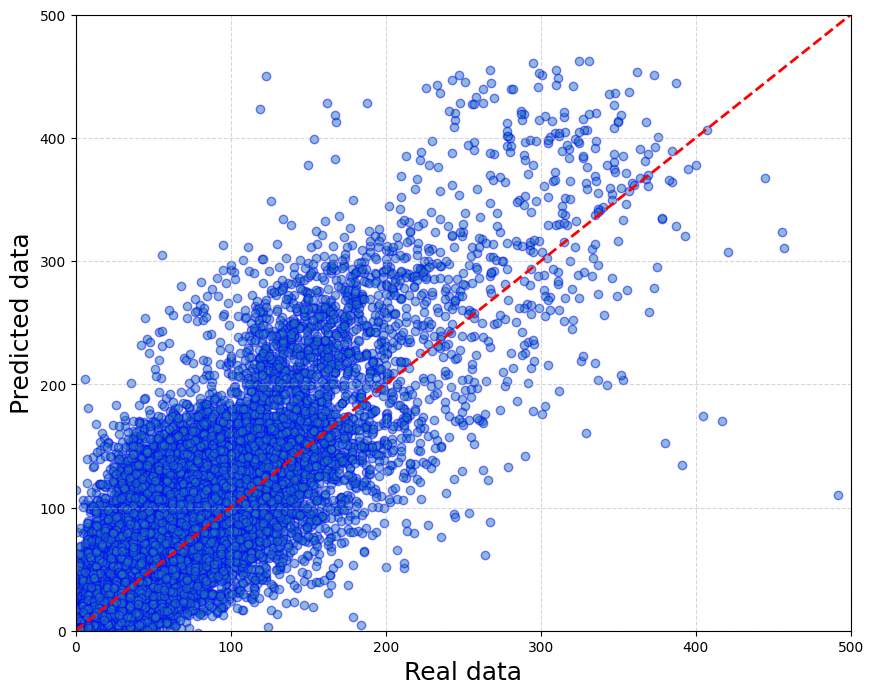

7/7 [==============================] - 2s 220ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 1.184
RMSE: 5.619
MAEs:  [2.848e+00 8.080e-01 4.200e-02 ... 2.000e-03 3.000e-03 2.000e-03]
RMSEs:  [4.522e+00 1.309e+00 1.760e-01 ... 3.000e-03 4.000e-03 2.000e-03]


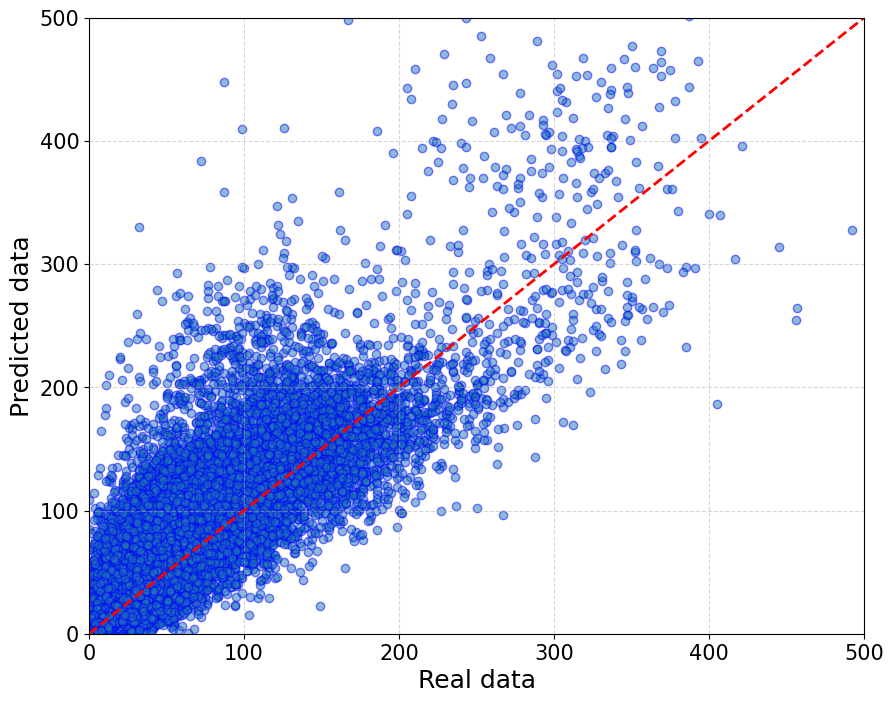

In [8]:
try:
    config = configurationManeger()
    evaluation_config = config.get_timeseries_evaluation_config()
    evaluation = TimeseriesEvaluation(evaluation_config)
    evaluation.evaluation()
    evaluation.save_score()
except Exception as e:
    raise CustomException(e, sys)